In [1]:
from tqdm import tqdm
import sys
from sklearn.model_selection import train_test_split
from torch.utils.data import (
    DataLoader, Dataset, RandomSampler, SubsetRandomSampler, Subset, SequentialSampler
)
from HOINet import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from search import *
import matplotlib.pyplot as plt
import torch
import numpy as np
import copy
import random
import argparse
import pickle
from util import *
# Multitask performance
# Gain distribution
# Estimation Error

load ETTm1
MTG-Net
iteration 1 0 0.1789 NN 0.1465 [ 1.465e-01 -1.000e+02  1.588e-01 -1.000e+02 -2.034e-01  2.270e-02
  1.495e-01]
iteration 1 1 -0.0883 NN -0.048 [-0.0432 -0.048  -0.0473 -0.0479 -0.0618  0.0382  0.1212]
iteration 1 2 0.2891 NN 0.1588 [ 1.465e-01 -1.000e+02  1.588e-01 -1.000e+02 -2.034e-01  2.270e-02
  1.495e-01]
iteration 1 3 -0.0514 NN -0.0479 [-0.0432 -0.048  -0.0473 -0.0479 -0.0618  0.0382  0.1212]
iteration 1 4 -0.0555 NN -0.0618 [-0.0432 -0.048  -0.0473 -0.0479 -0.0618  0.0382  0.1212]
iteration 1 5 0.0633 NN 0.0382 [-0.0432 -0.048  -0.0473 -0.0479 -0.0618  0.0382  0.1212]
iteration 1 6 0.1981 NN 0.1495 [ 1.465e-01 -1.000e+02  1.588e-01 -1.000e+02 -2.034e-01  2.270e-02
  1.495e-01]
iteration 2 0 0.0284 NN 0.1217 [ 1.217e-01 -1.000e+02  1.023e-01  3.910e-02 -4.280e-02 -1.000e+02
 -1.000e+02]
iteration 2 1 -0.0688 NN -0.0125 [-1.000e+02 -1.250e-02 -1.000e+02 -3.610e-02 -1.000e+02 -1.000e+02
  2.427e-01]
iteration 2 2 0.1505 NN 0.1023 [ 1.217e-01 -1.000e+02  1.023e-0

Text(0.5, 1.0, 'ETTm1, task num = 7')

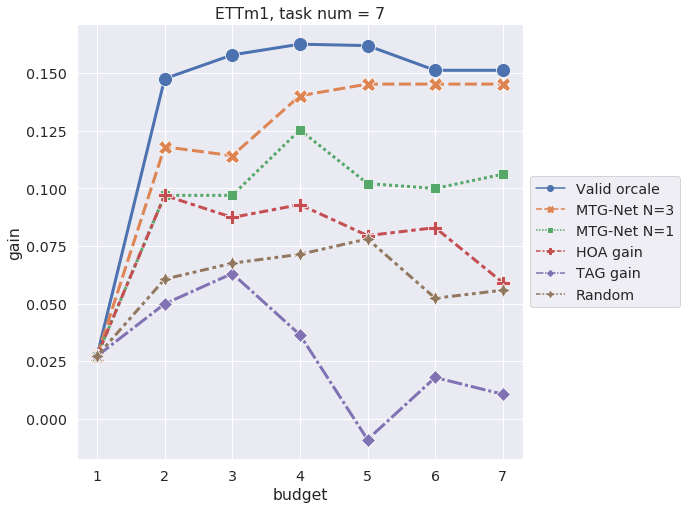

In [18]:
# search for multiple
dataset = 'ETTm1'
import pickle
with open('./log/'+dataset+'./pred_pertask_trajactiveper.pkl', "rb") as fp:   
    pred_traj = pickle.load(fp)
with open('./log/'+dataset+'./mask_pertask_trajactiveper.pkl', "rb") as fp:   
    pred_mask = pickle.load(fp)
select_index = []
pred_traj = np.array(pred_traj)[[-14,-1]]
pred_mask = np.array(pred_mask)[[-14,-1]]
x,y,testx,testy = getdataset(dataset,ratio)
validy = y
validx = x
HOApath = './gain_data/ETT/ETTm1/ETTm1_HOA.csv'
TAGpath = './gain_data/ETT/ETTm1/ETTm1_TAG_HOA.csv'
TAGy = pd.read_csv(TAGpath,header= None , sep=' ').values*0.01
HOAy = pd.read_csv(HOApath,header= None , sep=' ').values
sample_num = 3000
search_num = 7
print('MTG-Net')
total_gain_traj,total_select = approx_optimal(sample_num,search_num,pred_traj,testy,testx,dataset,pred_mask)
print('HOA')
total_HOA_gain_traj,HOA_select = approx_optimal(sample_num,search_num,[HOAy,HOAy],testy,testx,dataset,[validx,validx])
total_HOA_gain_traj = total_HOA_gain_traj[0]
print('TAG')
total_TAG_gain_traj,TAG_select = approx_optimal(sample_num,search_num,[TAGy,TAGy],testy,testx,dataset,[validx,validx])
total_TAG_gain_traj = total_TAG_gain_traj[0]
print('valid oracle select')
print('Oracle')
oracle_gain_traj,oracel_select = approx_optimal(sample_num,search_num,[validy,validy],testy,testx,dataset,[validx,validx])
# test_oracle_traj,oracel_select = approx_optimal(sample_num,search_num,testy,testy,testx,dataset)
oracle_gain_traj = oracle_gain_traj[0]
sample_num = 7
search_num = 1
budget = 7
total_traj=[]
for iteration in range(300):
    # print(iteration)
    rand_traj = []
    for num in range(1,8):
        while(True):
            sample_list = np.random.choice(np.arange(len(x)) ,size = num,replace = False )
            a = np.zeros((len(x[0])),)
            for i in x[sample_list]:
                a = a+i
            if(len(a[a==0])==0 ):
                value = np.zeros((len(x[0])))
                selected = validy[sample_list]
                test = testy[sample_list]
                testmask = testx[sample_list]
                for i in range(len(y[0])):
                    value[i] = test[np.argmax(selected[:,i])][i]
                break
        rand_traj.append(value.sum())
    total_traj.append(np.array(rand_traj))
random_traj = np.array(total_traj).mean(0)
x,y,testx,testy = getdataset(dataset,ratio)

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
cut_length = 7
NN_gain1 = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_gain_traj[0])[:cut_length]/7 })
rand_group = pd.DataFrame({'budget':list(range(1,cut_length+ 1)),'gain': random_traj/7 })
NN_gain = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_gain_traj[-1])[:cut_length]/7 })
HOA_gain = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_HOA_gain_traj)[:cut_length]/7 })
TAG_gain = pd.DataFrame({'budget':list(range(1,len(total_TAG_gain_traj)+1)),'gain': np.array(total_TAG_gain_traj)/7})
oracle_gain = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(oracle_gain_traj)[:cut_length]/7 })
HOA_gain['type'] = 'HOA gain'
TAG_gain['type'] = 'TAG gain'
NN_gain['type'] = 'MTG-Net N=3'
NN_gain1['type'] = 'MTG-Net N=1'
oracle_gain['type'] = 'Valid orcale'
rand_group['type'] = 'Random'
import seaborn as sns
all_gain = pd.concat([oracle_gain,NN_gain,NN_gain1,HOA_gain,TAG_gain,rand_group],axis=0)
sns.set(rc={'figure.figsize':(8,8)})
sns.set(font_scale=1.3)
g = sns.lineplot(x="budget", y="gain",hue="type",style='type', markers=True,linewidth = 3,markersize=14, data=all_gain)
g.set_xticks([1,2,3,4,5,6,7])
# g.set_yticks([0.040,0.044,0.05,0.1])
# plt.ylim(0,0.08)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("ETTm1, task num = 7")

load illness
load ETTm1


/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1af3282cc0> has a label of '_' which cannot be automatically added to the legend.
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1af3282eb8> has a label of '_' which cannot be automatically added to the legend.
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1af328fdd8> has a label of '_' which cannot be automatically added to the legend.
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1af328f278> has a label of '_' which cannot be automatically added to the legend.
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipyker

load ETTm1


/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:189: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


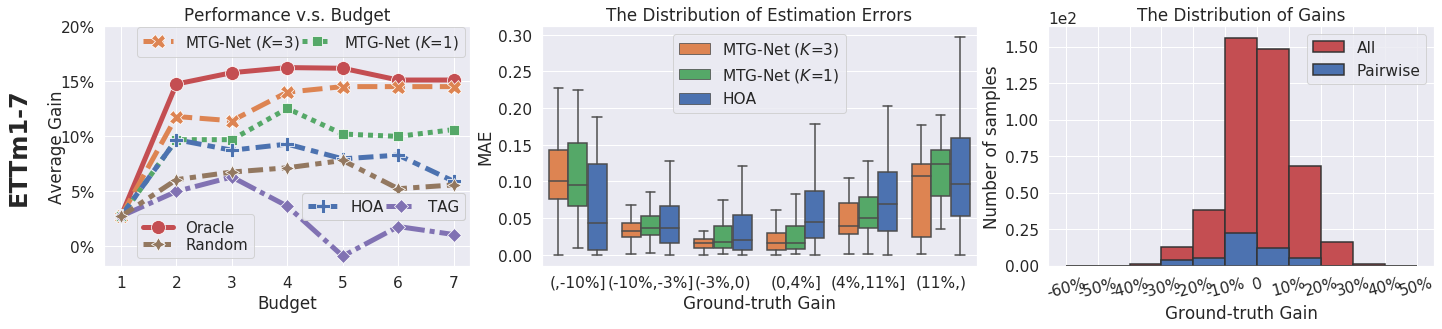

In [34]:
plt.switch_backend('agg')
dataset = 'illness'
x,y,testx,testy = getdataset(dataset,ratio)
plt.rcParams['pdf.use14corefonts'] = True
NN_gain1 = pd.DataFrame({'budget':list(range(1,8)),'gain': np.array(total_gain_traj[0])/7 })
NN_gain = pd.DataFrame({'budget':list(range(1,8)),'gain': np.array(total_gain_traj[-1])/7 })
HOA_gain = pd.DataFrame({'budget':list(range(1,8)),'gain': np.array(total_HOA_gain_traj)/7 })
TAG_gain = pd.DataFrame({'budget':list(range(1,8)),'gain': np.array(total_TAG_gain_traj)/7})
oracle_gain = pd.DataFrame({'budget':list(range(1,8)),'gain': np.array(oracle_gain_traj)/7 })
rand_group = pd.DataFrame({'budget':list(range(1,8)),'gain': random_traj/7 })
HOA_gain['type'] = 'HOA'
NN_gain['type'] = 'MTG-Net ($K$=3)'
NN_gain1['type'] = 'MTG-Net ($K$=1)'
oracle_gain['type'] = 'Oracle'
TAG_gain['type'] = 'TAG'
rand_group['type'] = 'Random'
import seaborn as sns
all_gain = pd.concat([oracle_gain,NN_gain,NN_gain1,HOA_gain,TAG_gain,rand_group],axis=0)
gs = gridspec.GridSpec(2, 140)
plt.figure(figsize=(24.9,4.4))
ax_title = plt.subplot(gs[:,:6])
ax_title.grid(False)
ax_title.set_facecolor('white')
ax_title.set_xticklabels([])
ax_title.set_ylabel('ETTm1-7',fontsize=24,fontweight="bold")
ax_title.set_yticklabels([])
ax1 = plt.subplot(gs[:,6:43])
# plt.figure(figsize=(20,4))
sns.set(font_scale=1.4)
mypalette = [sns.color_palette()[3],sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0],sns.color_palette()[4],sns.color_palette()[5]]
# mypalette = [sns.color_palette()[3],sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[4],sns.color_palette()[5]]
sns.lineplot(x="budget", y="gain",hue="type",style='type', markers=True,linewidth = 5,markersize=14,palette=mypalette, data=all_gain, ax = ax1,ci=0,markevery=1)
plt.ylabel('Average Gain',labelpad=-5)
ax1.set_xticks([1,2,3,4,5,6,7])
ax1.set_yticks([0,0.05,0.1,0.15,0.2])
ax1.set_yticklabels(['0%','5%','10%','15%','20%'])
ax1.set_xlabel('Budget')
plt.legend()
l1 = ax1.legend(['Oracle','_','_','_','_','Random'],ncol = 1,loc='lower left',bbox_to_anchor=(0.07,0.00),fontsize=15,columnspacing=0.15,labelspacing=0.15)
l2 = ax1.legend(['_','_','_','HOA','TAG','_'],ncol = 2,loc='lower left',bbox_to_anchor=(0.52,0.16),fontsize=15,columnspacing=0.15,labelspacing=0.15)
ax1.add_artist(l1)
ax1.add_artist(l2)
ax1.legend(['_','MTG-Net ($K$=3)','MTG-Net ($K$=1)'],ncol = 2,loc='lower left',bbox_to_anchor=(0.07,0.84),fontsize=15,columnspacing=0.15,labelspacing=0.15)
ax1.add_artist(l2)
plt.title("Performance v.s. Budget")
ax2 = plt.subplot(gs[:,101:147])
plt.title('The Distribution of Gains')
x,y,testx,testy = getdataset('ETTm1',ratio)
HOA = pd.read_csv(HOApath,header= None , sep=' ').values
import copy
y_n2 = y
P_n2 = HOA
ground_truth = y
range0 = np.percentile(y[y<0],0)
range1 = np.percentile(y[y<0],33)
range2 = np.percentile(y[y<0],66)
range3 = 0
range4 = np.percentile(y[y>0],33)
range5 = np.percentile(y[y>0],66)
range6 = np.percentile(y[y>0],100)
boxplot_x = np.array([range0,range1,range2,range3,range4,range5,range6])
num_list = np.array([0.00,0.005,0.01,0.015])
total_width, n = 0.001, 2
width = total_width
num_list1 = num_list- width
bin_sel = np.array(list(range(-600,600,100)))*0.001
total_output = copy.deepcopy(pred_traj[-1])
total_output[total_output==-99] = 0
name_list = ['-60%','-50%','-40%','-30%','-20%','-10%','0','10%','20%','30%','40%','50%']
plt.xticks(bin_sel,name_list)
dataset = 'ETTm1'
x,y,testx,testy = getdataset(dataset,ratio)
plt.hist(y[y!=0], bins=bin_sel, normed=0, color=sns.color_palette()[3],linewidth=1.5,edgecolor =(0.2,0.2,0.2),label='All', alpha=1)
plt.hist(y[:30][y[:30]!=0], bins=bin_sel, normed=0, color=sns.color_palette()[0],linewidth=1.5,edgecolor =(0.2,0.2,0.2),label='Pairwise', alpha=1)
plt.xticks(rotation=15)
ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
plt.legend()
plt.xlabel('Ground-truth Gain')
plt.ylabel('Number of samples')
name_list = ['(,-10%]','(-10%,-3%]','(-3%,0)','(0,4%]','(4%,11%]','(11%,)']
with open('./log/'+dataset+'/pred_pertask_trajactiveper.pkl', "rb") as fp:   
    pred_traj = pickle.load(fp)
model_pred = np.array(pred_traj)[[-14,-1]]
average_boxplot= []
total_output = copy.deepcopy(model_pred)[-1]
for i in range(len(boxplot_x)-1):
    average_boxplot.append(abs(P_n2[((y_n2>boxplot_x[i]) & (y_n2<boxplot_x[i+1]))] - y_n2[((y_n2>boxplot_x[i]) & (y_n2<boxplot_x[i+1]))] ))
NN_boxplot = []
for i in range(len(boxplot_x)-1):
    NN_boxplot.append(abs(total_output[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] - ground_truth[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] ))
import pandas as pd
type_column = []
MAE_column = []
Range_column = []
for i in range(len(name_list)):
    for j in average_boxplot[i]:
        type_column.append('HOA')
        MAE_column.append(j)
        Range_column.append(name_list[i])
df_set = {'type':type_column,
        'MAE':MAE_column,
        'Range':Range_column}
df_average = pd.DataFrame(data = df_set)

import pandas as pd
type_column = []
MAE_column = []
Range_column = []
for i in range(len(name_list)):
    for j in NN_boxplot[i]:
        type_column.append('MTG-Net ($K$=3)')
        MAE_column.append(j)
        Range_column.append(name_list[i])
df_set = {'type':type_column,
        'MAE':MAE_column,
        'Range':Range_column}
df_NN1 = pd.DataFrame(data = df_set)

# all_average1 = pd.concat([df_average,df_NN],axis=0)

total_output = copy.deepcopy(model_pred[-2])
NN_boxplot = []
for i in range(len(boxplot_x)-1):
    NN_boxplot.append(abs(total_output[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] - ground_truth[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] ) )
import pandas as pd
type_column = []
MAE_column = []
Range_column = []
# df_NN2 = pd.DataFrame(columns=['type','MAE','Range'])
for i in range(len(name_list)):
    for j in NN_boxplot[i]:
        type_column.append('MTG-Net ($K$=1)')
        MAE_column.append(j)
        Range_column.append(name_list[i])
df_set = {'type':type_column,
        'MAE':MAE_column,
        'Range':Range_column}
df_NN2 = pd.DataFrame(data = df_set)

all_average = pd.concat([df_NN1,df_NN2,df_average],axis=0)
ax3 = plt.subplot(gs[:,50:94])
sns.boxplot(x="Range", y="MAE",
                hue="type", palette= (sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0]),
                data=all_average,showfliers = False,saturation=1 )
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles[0:], labels=labels[0:])
plt.xlabel('Ground-truth Gain')
plt.title('The Distribution of Estimation Errors')
plt.tight_layout()
plt.show()